In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [ ]:
batchSize = 16 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

In [ ]:
transform = transforms.Compose([transforms.Scale(imageSize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir(r'/content/gdrive/My Drive/iss/psupr/project')
dpath = "./dataset"
dataset = dset.ImageFolder(root = dpath, transform = transform) 
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = 2)

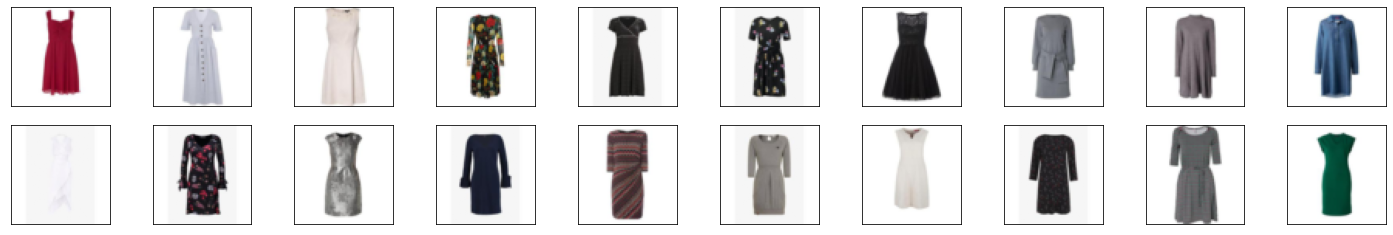

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
    
dataiter = iter(dataloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class G(nn.Module):
    
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
        nn.ConvTranspose2d(100,512,4,1,0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512,256,4,2,1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256,128,4,2,1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128,64,4,2,1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64,3,4,2,1,bias=False),
        nn.Tanh()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
class D(nn.Module):
    
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3,64,4,2,1,bias=False),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Conv2d(64,128,4,2,1,bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Conv2d(128,256,4,2,1,bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Conv2d(256,512,4,2,1,bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Conv2d(512,1,4,1,0,bias=False),
                nn.Sigmoid()
                )
        
    def forward(self,input):
        output = self.main(input)
        return output.view(-1)

In [ ]:
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(),lr = 0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(),lr = 0.0002, betas=(0.5,0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
for epoch in range(100):
    
    for i, data in enumerate(dataloader,0):
        
        netD.zero_grad()
        
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output,target)
        
        noise = Variable(torch.randn(input.size()[0],100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        
        errG.backward()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' %(epoch,100,i,len(dataloader),errD.data, errG.data))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i%100 == 0:
            #vutils.save_image(real,'%s/real_samples.png'% "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data,'%s/generator_samples_epoch_%03d.png'% ("./results_64", epoch), normalize=True)
    
    

In [ ]:
torch.save(netD.state_dict(), "/content/gdrive/My Drive/iss/psupr/project/results_64/netD.pth")


In [ ]:
torch.save(netG.state_dict(), "/content/gdrive/My Drive/iss/psupr/project/results_64/netG.pth")


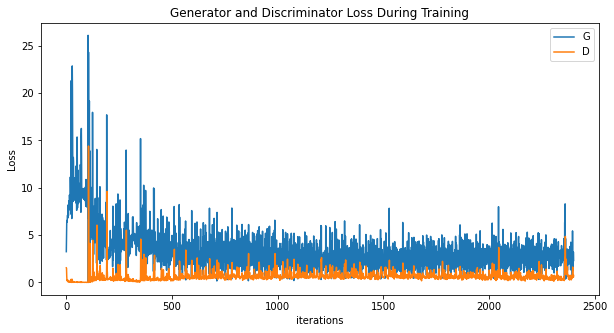

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
anim_file = 'dcgan.gif'
os.chdir(r'/content/gdrive/My Drive/iss/psupr/project/results_64')

import imageio
import glob
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generator*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image) 

In [ ]:

real,_ = next(iter(dataloader))
input = Variable(real)
noise = Variable(torch.randn(input.size()[0],100, 1, 1))
fake = netG1(noise)

In [ ]:
img_list = []
img_list.append(vutils.make_grid(fake.detach(), padding=2, normalize=True))

In [ ]:
dataiter = iter(fake.data)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

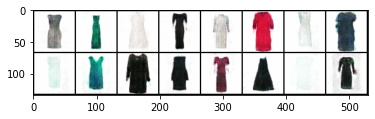

In [ ]:
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

In [ ]:
len(fake.data)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


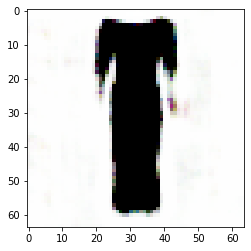

In [ ]:
plt.imshow(np.transpose(fake.data[3],(1,2,0)))

In [ ]:
netG1 = G()

In [ ]:
netG1.load_state_dict(torch.load("/content/gdrive/My Drive/iss/psupr/project/results_64/netG.pth"))
netG1.eval()

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
netD1 = D()

In [ ]:
netD1.load_state_dict(torch.load("/content/gdrive/My Drive/iss/psupr/project/results_64/netD.pth"))
netD1.eval()

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD1.parameters(),lr = 0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(netG1.parameters(),lr = 0.0002, betas=(0.5,0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0
for epoch in range(2):
    
    for i, data in enumerate(dataloader,0):
        
        netD1.zero_grad()
        
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD1(input)
        errD_real = criterion(output,target)
        
        noise = Variable(torch.randn(input.size()[0],100, 1, 1))
        fake = netG1(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD1(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        netG1.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD1(fake)
        errG = criterion(output, target)
        
        errG.backward()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' %(epoch,100,i,len(dataloader),errD.data, errG.data))

        if i%20 == 0:
          vutils.save_image(real,'%s/real_samples.png'% "./results", normalize=True)
          fake = netG(noise)
          vutils.save_image(fake.data,'%s/generator_samples_epoch_%03d.png'% ("./results", epoch), normalize=True)  
    
    

In [ ]:
vutils.save_image(fake.data[9],'%s/_[9]%03d.png'% ("./results", epoch))

In [ ]:
vutils.save_image(real[9],'%s/real_samples[9].png'% "./results", normalize=True)


In [ ]:
print(output.size())
print(input.size())
print(target.size())
print(fake.size())
print(type(input))

torch.Size([64])
torch.Size([64, 3, 64, 64])
torch.Size([64])
torch.Size([64, 3, 64, 64])
<class 'torch.Tensor'>


In [ ]:
x = 10 
y = 11
print(str(x)+str(y))